## Training / Evaluating NeuralNets

Sections:
- Imports
- Data exploration
- NN Architectures
- Lightning wrapper for architectures
- Hyperparameters tuning
    - Preparing dataloader and pruner
    - LSTM grid-search
    - TCN grid-search
    - ANN grid-search
- Examining results (logs) of hyperparams tuning
- Training models with best hyperparams to visualise results
    - Dataloader
    - Plot loss function
    - LSTM (Best model)
    - TCN (Best hparams)
    - ANN (Best hparams)
- Shap values for the best model

### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import math
import re
import sys
import pickle
from tqdm import tqdm
import warnings

# PyTorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torchmetrics.functional.regression import symmetric_mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

# Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from packaging import version

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Scipy
from scipy.interpolate import interp1d

# Visualization
import seaborn as sn
sn.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime
import plotly.figure_factory as ff
import shap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data exploration

In [ ]:
# Column indicating patients
sepsis_df.groupby('File_Path').size()

In [ ]:
# Plotting the pandas describe table
sepsis_df.describe().map("{0:.4f}".format)

In [ ]:
sepsis_df.isna().sum()/sepsis_df.shape[0]

In [ ]:
# Possibly the distribution of missing data is skewed
sepsis_df[sepsis_df['SepsisLabel']==1].isna().sum()/sepsis_df.shape[0]

In [ ]:
# Group by 'File_Path' and check if there is at least one 'SepsisLabel' equal to 1 in each group
grouped = sepsis_df.groupby('File_Path')['SepsisLabel'].any().reset_index()

# Identify the groups where 'SepsisLabel' is equal to 1
groups_with_sepsis = grouped[grouped['SepsisLabel'] == 1]['File_Path'].tolist()

# Update the entire group to have 'SepsisLabel' equal to 1
sepsis_df.loc[sepsis_df['File_Path'].isin(groups_with_sepsis), 'SepsisLabel'] = 1

In [ ]:
sepsis_df.to_csv('all_sample_data_target_recode.csv')

In [ ]:
# Is the distribution of missing data skewed?
sepsis_df[sepsis_df['SepsisLabel']==1].isna().sum()/sepsis_df.shape[0]

In [ ]:
# Possibly the distribution of missing data skewed? (No)
sepsis_df[sepsis_df['SepsisLabel']==0].isna().sum()/sepsis_df.shape[0]

In [ ]:
# Filter the DataFrame for rows where 'SepsisLabel' is equal to 0
filtered_df = sepsis_df[sepsis_df['SepsisLabel'] == 0]

# Group by 'File_Path' for the filtered DataFrame
grouped_df = filtered_df.groupby('File_Path')

# Identify groups with at least one column having all values as null
groups_with_all_nulls = []

for group_name, group_data in grouped_df:
    if group_data.isnull().all(axis=0).any():
        groups_with_all_nulls.append(group_name)

# Calculate the percentage of groups with at least one column having all values as null
percentage_groups_with_all_nulls = (len(groups_with_all_nulls) / len(grouped_df)) * 100

print(f"Percentage of groups with at least one column having all values as null: {percentage_groups_with_all_nulls:.2f}%")

In [ ]:
# We don't have any extreme/unnatural observations (Although we have statistical outliers)
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'sepsis_df' is DataFrame
# You may want to exclude non-numeric columns if they are not suitable for histograms
numeric_columns = sepsis_df.select_dtypes(include=[np.number]).columns

# Set the style for the plots
sns.set(style="whitegrid")

# Determine the number of rows and columns dynamically based on the number of numeric columns
num_plots = len(numeric_columns)
num_cols = min(4, num_plots)  # Maximum of 3 columns per row
num_rows = -(-num_plots // num_cols)  # Ceiling division to calculate the number of rows

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)

# Flatten the axes array if it's a 2D array
axes = axes.flatten() if num_rows > 1 else [axes]

# Plot histograms for each numeric column with density
for i, column in enumerate(numeric_columns):
    sns.histplot(sepsis_df[column], kde=True,  bins=40,  stat='percent', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Remove any empty subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [ ]:
sepsis_df.to_csv('sepsis_target_recode.csv')

### NN Architectures

In [12]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate, activ):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.activ = activ
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size,
                                 out_features=self.out_features)

    def forward(self, X):
        X, _ = self.lstm(X)
        # Picking the last output
        X = self.activ(X[:,-1,:])
        X = self.linear1(X)

        return X

In [13]:
class TemporalCNNModel(nn.Module):
    def __init__(self, in_channels=10,
                 out_channels=10,
                 kernel_size=3,
                 dropout_rate=0.2,
                 output_size=1,
                 num_conv_layers=3):
        super(TemporalCNNModel, self).__init__()

        # Define a list to hold the convolutional layers
        self.conv_layers = nn.ModuleList()

        # Add the first convolutional layer
        self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size))
        self.conv_layers.append(nn.ReLU())
        self.conv_layers.append(nn.Dropout(dropout_rate))

        # Add additional convolutional layers
        for _ in range(1, num_conv_layers):
            self.conv_layers.append(nn.Conv1d(out_channels, out_channels, kernel_size))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.Dropout(dropout_rate))

        # Pooling layer
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, X):
        X = X.permute(0, 2, 1) # X was prepared for LSTM
        for layer in self.conv_layers:
            X = layer(X)

        X = self.pool(X)
        X = X.view(X.size(0), -1)  # Flatten for fully connected layer
        X = self.fc(X)
        return X

In [14]:
class ANNModel(nn.Module):
    def __init__(self, in_size=15,
                 h_sizes=[60,30,15],
                 out_size=1,
                 dropout_rate=0.2,
                 activ=nn.ReLU):
        super().__init__()
        self.input_size = in_size
        self.hidden_sizes = h_sizes
        self.output_size = out_size
        self.dropout_rate = dropout_rate
        self.activ = activ()

        # Create a list to hold the fully connected layers
        self.fc_layers = nn.ModuleList()

        # Add input layer
        self.fc_layers.append(nn.Linear(in_features=self.input_size, out_features=self.hidden_sizes[0]))

        # Add hidden layers
        for i in range(1, len(self.hidden_sizes)):
            self.fc_layers.append(nn.Linear(in_features=self.hidden_sizes[i-1], out_features=self.hidden_sizes[i]))

        # Output layer
        self.fc_layers.append(nn.Linear(in_features=self.hidden_sizes[-1], out_features=self.output_size))

        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, X):
        for layer in self.fc_layers[:-1]:
            X = self.activ(layer(X))
            X = self.dropout(X)

        # Output layer without activation function
        X = self.fc_layers[-1](X)[:,-1,:]
        return X


### Lightning wrapper for architectures

In [15]:
# Wrapper for models created with lightning
class ModelWrapped(pl.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice
        self.model = model
        # Learning rate
        self.lr = lr

        self.val_step_outputs = []
        self.val_step_targets = []
        self.val_losses = []

        self.predictions = []
        self.targets = []
        self.train_losses = []

    def training_step(self, batch):
        X, y = batch
        y_pred = self.model(X).squeeze()
        pos_weight = torch.tensor(8)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        train_loss = criterion(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=True, on_epoch=False, sync_dist=True)

        self.predictions.extend(y_pred.unsqueeze(0))
        self.targets.extend(y.unsqueeze(0))
        self.train_losses.append(train_loss)

        return train_loss
    
    def on_train_epoch_end(self):
        all_predictions =  torch.cat(self.predictions, dim=0).detach().cpu().numpy()
        all_targets = torch.cat(self.targets, dim=0).detach().cpu().numpy()

        # Calculate average train loss
        avg_train_loss = torch.stack(self.train_losses).mean()

        # Calculate average validation ROC_AUC
        roc_auc = roc_auc_score(all_targets, all_predictions)

        self.log("train_epoch_loss", avg_train_loss.item(), prog_bar=True, on_epoch=True, sync_dist=True)
        self.log("train_epoch_roc_auc", roc_auc, prog_bar=True, on_epoch=True, sync_dist=True)

        self.train_losses.clear()
        self.predictions.clear()
        self.targets.clear()

    def validation_step(self, batch):
        X, y = batch
        y_pred = self.model(X).squeeze()
        pos_weight = torch.tensor(8)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        val_loss = criterion(y_pred, y)
        
        self.val_step_outputs.extend(y_pred.unsqueeze(0))
        self.val_step_targets.extend(y.unsqueeze(0))
        self.val_losses.append(val_loss)
        self.log("val_loss", val_loss, prog_bar=True, on_step=True, on_epoch=False, sync_dist=True)

    def on_validation_epoch_end(self):
        if len(self.val_step_outputs) > 2000:
            val_all_outputs =  torch.cat(self.val_step_outputs, dim=0).detach().cpu().numpy()
            val_all_targets = torch.cat(self.val_step_targets, dim=0).detach().cpu().numpy()
            
            # Calculate average validation loss
            avg_val_loss = torch.stack(self.val_losses).mean()
            
            # Calculate average validation ROC_AUC
            roc_auc = roc_auc_score(val_all_targets, val_all_outputs)

            self.log("val_epoch_loss", avg_val_loss.item(), prog_bar=True, on_epoch=True, sync_dist=True)
            self.log("val_epoch_roc_auc", roc_auc, prog_bar=True, on_epoch=True, sync_dist=True)

            self.val_losses.clear()
            self.val_step_outputs.clear()
            self.val_step_targets.clear()
        else:
            pass

    def predict_step(self, batch):
        with torch.no_grad():
            X, y = batch
            y_pred = self.model(X).squeeze()
        return y_pred
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Hyperparameters tuning

#### Preparing Dataloader and Pruner

In [21]:
import dataloader_wrapper_cuda
import importlib

importlib.reload(dataloader_wrapper_cuda)

# Pruner
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

# Load the scaler from a pickle file
scaler_filename = os.path.join('scalers_imputers_for_sample_all', 'min_max_scaler_all_feat.pkl')
with open(scaler_filename, 'rb') as file:
    scaler = pickle.load(file)

# Load the imputer from a pickle file
imputer_filename = os.path.join('scalers_imputers_for_sample_all', 'bayesian_imputer_all_feat.pkl')
with open(imputer_filename, 'rb') as file:
    imputer = pickle.load(file)


dm = dataloader_wrapper_cuda.SepsisDataLoader(train_dir="data/all/all_sample_data_target_recode.csv",
                          seq_len=20,
                          X_scaler=scaler,
                          X_imputer=imputer,
                          test_size=0.3,
                          random_state=42,
                          batch_size=256,
                          training_size=1,
                          num_workers=6,
                          device=device
                          )
dm.prepare_for_training()

train val test id nums 28234 6051 6051
uniq filepaths, len filepaths 40336 1552210
flag0 (1087188, 53) (233589, 53) (231433, 53)


[IterativeImputer] Early stopping criterion not reached.
100%|██████████| 6051/6051 [00:12<00:00, 480.68it/s]


In [22]:
# # Save the model to a file using pickle
model_filename = os.path.join('scalers_imputers_for_sample_all', 'min_max_scaler_all_feat.pkl')
with open(model_filename, 'wb') as file:
    pickle.dump(dm.X_scaler, file)

# Save the model to a file using pickle
model_filename = os.path.join('scalers_imputers_for_sample_all', 'bayesian_imputer_all_feat.pkl')
with open(model_filename, 'wb') as file:
    pickle.dump(dm.X_imputer, file)

In [24]:
imputer.feature_names_in_

array(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT',
       'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1',
       'ICULOS', 'hr_o2sat_interaction', 'hr_sbp_interaction',
       'mpa_dbp_interaction', 'o2sat_resp_interaction',
       'temp_resp_interaction', 'age_resp_interaction', 'Temp_diff',
       'DBP_diff', 'Resp_diff', 'SBP_diff', 'O2Sat_diff', 'MAP_diff',
       'HR_diff'], dtype=object)

#### LSTM grid-search

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    h_size = trial.suggest_categorical('h_size',[16, 32, 48])
    num_l = trial.suggest_categorical('num_l',[2])
    dropout_rate = trial.suggest_categorical('dropout_rate',[0.2, 0.4])
    activ = nn.ReLU
    lr = trial.suggest_categorical('lr', [1e-3, 1e-2])
    # We optimize the number of layers, hidden units in each layer and dropouts.
    dropout = trial.suggest_categorical('dropout', [0.2])

    torch_model = LSTMModel(in_size=51,
                                h_size=h_size,
                                num_l=num_l,
                                out_f=1,
                                dropout_rate=dropout_rate,
                                activ=activ()).to(device)
    model = ModelWrapped(torch_model,
                         lr=lr).to(device)

    callback = OptunaPruning(trial, monitor="val_loss")
    trainer = pl.Trainer(
        logger=True,
        default_root_dir='logs_20_window_all_data/lstm_logs/',
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=10,
        accelerator="gpu",
        callbacks=[callback],        
    )
    hyperparameters = dict(seq_len = 20,
                            h_size = h_size,
                            num_l = num_l,
                            dropout_rate = dropout_rate,
                            activ = activ,
                            lr = lr,
                            batch_size = 32
                            )
    trainer.logger.log_hyperparams(hyperparameters)
    pl.seed_everything(0)
    trainer.fit(model, datamodule=dm)
    callback.check_pruned()
    
    # Free up memory
    del model
    torch.cuda.empty_cache()
    return trainer.callback_metrics["val_epoch_roc_auc"].item()

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
#torch.set_float32_matmul_precision('medium')
study = optuna.create_study(direction="maximize", pruner=pruner)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

study.optimize(objective, n_trials=12)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    h_size = trial.suggest_categorical('h_size',[16, 32, 48])
    num_l = trial.suggest_categorical('num_l',[4])
    dropout_rate = trial.suggest_categorical('dropout_rate',[0.2, 0.4])
    activ = nn.ReLU
    lr = trial.suggest_categorical('lr', [1e-3, 1e-2])
    # We optimize the number of layers, hidden units in each layer and dropouts.
    dropout = trial.suggest_categorical('dropout', [0.2])

    torch_model = LSTMModel(in_size=51,
                                h_size=h_size,
                                num_l=num_l,
                                out_f=1,
                                dropout_rate=dropout_rate,
                                activ=activ()).to(device)
    model = ModelWrapped(torch_model,
                         lr=lr)

    callback = OptunaPruning(trial, monitor="val_loss")
    trainer = pl.Trainer(
        logger=True,
        default_root_dir='logs_20_window_all_data/lstm_logs',
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=10,
        accelerator="gpu",
        callbacks=[callback],
    )
    hyperparameters = dict(seq_len = 20,
                            h_size = h_size,
                            num_l = num_l,
                            dropout_rate = dropout_rate,
                            activ = activ,
                            lr = lr,
                            batch_size = 32
                            )
    trainer.logger.log_hyperparams(hyperparameters)
    pl.seed_everything(0)
    trainer.fit(model, datamodule=dm)
    callback.check_pruned()
    return trainer.callback_metrics["val_epoch_roc_auc"].item()

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(direction="maximize", pruner=pruner)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

study.optimize(objective, n_trials=12)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-05-26 02:29:18,146] A new study created in memory with name: no-name-12fdb496-a5eb-4b1f-bee0-2f5c336582bb
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:33:48,932] Trial 0 finished with value: 0.8396453857421875 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:38:20,921] Trial 1 finished with value: 0.5118355751037598 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 75.9 K
------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.304     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:42:49,763] Trial 2 finished with value: 0.8359081149101257 and parameters: {'h_size': 48, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:47:19,541] Trial 3 finished with value: 0.5 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.2, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:51:50,314] Trial 4 finished with value: 0.5118355751037598 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 02:56:21,467] Trial 5 finished with value: 0.838114321231842 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.2, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 75.9 K
------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.304     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:00:50,682] Trial 6 finished with value: 0.5 and parameters: {'h_size': 48, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 11.0 K
------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:05:24,542] Trial 7 finished with value: 0.8380300402641296 and parameters: {'h_size': 16, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 11.0 K
------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:09:57,324] Trial 8 finished with value: 0.8296300768852234 and parameters: {'h_size': 16, 'num_l': 4, 'dropout_rate': 0.2, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 11.0 K
------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:14:30,553] Trial 9 finished with value: 0.5116271376609802 and parameters: {'h_size': 16, 'num_l': 4, 'dropout_rate': 0.4, 'lr': 0.01, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:19:00,372] Trial 10 finished with value: 0.838114321231842 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.2, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 36.3 K
------------------------------------
36.3 K    Trainable params
0         Non-trainable params
36.3 K    Total params
0.145     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:23:29,888] Trial 11 finished with value: 0.838114321231842 and parameters: {'h_size': 32, 'num_l': 4, 'dropout_rate': 0.2, 'lr': 0.001, 'dropout': 0.2}. Best is trial 0 with value: 0.8396453857421875.


Number of finished trials: 12
Best trial:
Value: 0.8396453857421875
Params: 
 h_size: 32
 num_l: 4
 dropout_rate: 0.4
 lr: 0.001
 dropout: 0.2


#### TCN grid-search

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    seq_len = trial.suggest_categorical('seq_len',[20])
    num_tcn_channels  = trial.suggest_categorical('num_tcn_channels',[15,
                                            20, 40])
    dropout_rate = trial.suggest_categorical('dropout_rate',[0.2])
    activ = nn.ReLU
    lr = trial.suggest_categorical('lr',[1e-3, 1e-2])
    batch_size = 32
    # We optimize the number of layers, hidden units in each layer and dropouts.
    n_layers = trial.suggest_categorical('n_layers', [2, 4])
    dropout = trial.suggest_categorical('dropout', [0.2, 0.4])

    torch_model = TemporalCNNModel(in_channels=51,
                 out_channels=num_tcn_channels,
                 kernel_size=3,
                 dropout_rate=0.2,
                 output_size=1,
                 num_conv_layers=n_layers).to(device)
    model = ModelWrapped(torch_model,
                         lr=lr)

    callback = OptunaPruning(trial, monitor="val_loss")
    trainer = pl.Trainer(
        logger=True,
        default_root_dir='logs_20_window_all_data/tcn_logs/',
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        callbacks=[callback],
    )
    hyperparameters = dict(seq_len = seq_len,
                            num_hidden_channels  = num_tcn_channels,
                            dropout_rate = dropout_rate,
                            activ = activ,
                            lr = lr,
                            batch_size = batch_size,
                            n_layers = n_layers,
                            dropout = dropout)
    trainer.logger.log_hyperparams(hyperparameters)
    pl.seed_everything(0)
    trainer.fit(model, datamodule=dm)
    callback.check_pruned()
    return trainer.callback_metrics["val_epoch_roc_auc"].item()

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(direction="maximize", pruner=pruner)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

study.optimize(objective, n_trials=24)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-05-26 03:23:29,925] A new study created in memory with name: no-name-81d3fa8a-95b7-4b76-b38e-8bf08b36180f
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 4.4 K 
-------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:28:10,956] Trial 0 finished with value: 0.8320110440254211 and parameters: {'seq_len': 20, 'num_tcn_channels': 15, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 0 with value: 0.8320110440254211.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 11.0 K
-------------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:32:29,531] Trial 1 finished with value: 0.8201298117637634 and parameters: {'seq_len': 20, 'num_tcn_channels': 40, 'dropout_rate': 0.2, 'lr': 0.01, 'n_layers': 2, 'dropout': 0.4}. Best is trial 0 with value: 0.8320110440254211.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 4.3 K 
-------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:36:52,860] Trial 2 finished with value: 0.8320616483688354 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 2, 'dropout': 0.4}. Best is trial 2 with value: 0.8320616483688354.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 4.4 K 
-------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:41:33,512] Trial 3 finished with value: 0.809318482875824 and parameters: {'seq_len': 20, 'num_tcn_channels': 15, 'dropout_rate': 0.2, 'lr': 0.01, 'n_layers': 4, 'dropout': 0.2}. Best is trial 2 with value: 0.8320616483688354.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:46:12,827] Trial 4 finished with value: 0.8328612446784973 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 4 with value: 0.8328612446784973.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:50:52,213] Trial 5 finished with value: 0.8134953379631042 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.01, 'n_layers': 4, 'dropout': 0.4}. Best is trial 4 with value: 0.8328612446784973.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 11.0 K
-------------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:55:12,004] Trial 6 finished with value: 0.8319909572601318 and parameters: {'seq_len': 20, 'num_tcn_channels': 40, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 2, 'dropout': 0.4}. Best is trial 4 with value: 0.8328612446784973.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 03:59:51,710] Trial 7 finished with value: 0.8340673446655273 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:04:30,325] Trial 8 finished with value: 0.8120696544647217 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.01, 'n_layers': 4, 'dropout': 0.4}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 4.4 K 
-------------------------------------------
4.4 K     Trainable params
0         Non-trainable params
4.4 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:09:10,425] Trial 9 finished with value: 0.8142778277397156 and parameters: {'seq_len': 20, 'num_tcn_channels': 15, 'dropout_rate': 0.2, 'lr': 0.01, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 4.3 K 
-------------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:13:32,614] Trial 10 finished with value: 0.8312419056892395 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 2, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:18:11,727] Trial 11 finished with value: 0.8316318392753601 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:22:51,528] Trial 12 finished with value: 0.8332603573799133 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:27:30,484] Trial 13 finished with value: 0.8306042551994324 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 20.7 K
-------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:32:07,476] Trial 14 finished with value: 0.8320550322532654 and parameters: {'seq_len': 20, 'num_tcn_channels': 40, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:36:46,412] Trial 15 finished with value: 0.8337178230285645 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:41:26,322] Trial 16 finished with value: 0.8316208124160767 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:46:06,230] Trial 17 finished with value: 0.8331710696220398 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 3.0 K 
-------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:50:28,445] Trial 18 finished with value: 0.8308278322219849 and parameters: {'seq_len': 20, 'num_tcn_channels': 15, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 2, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 20.7 K
-------------------------------------------
20.7 K    Trainable params
0         Non-trainable params
20.7 K    Total params
0.083     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:55:04,389] Trial 19 finished with value: 0.8331168293952942 and parameters: {'seq_len': 20, 'num_tcn_channels': 40, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 04:59:44,376] Trial 20 finished with value: 0.8323656320571899 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:04:23,947] Trial 21 finished with value: 0.8295324444770813 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:09:03,158] Trial 22 finished with value: 0.8317019939422607 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:13:43,072] Trial 23 finished with value: 0.8311377763748169 and parameters: {'seq_len': 20, 'num_tcn_channels': 20, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'dropout': 0.2}. Best is trial 7 with value: 0.8340673446655273.


Number of finished trials: 24
Best trial:
Value: 0.8340673446655273
Params: 
 seq_len: 20
 num_tcn_channels: 20
 dropout_rate: 0.2
 lr: 0.001
 n_layers: 4
 dropout: 0.2


#### ANN grid-search

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    seq_len = trial.suggest_categorical('seq_len',[20])
    h_size = trial.suggest_categorical('h_size',[16, 32])
    ann_hidden_sizes = trial.suggest_categorical('ann_hidden_size',[[60,30,15],
                                            [80,40,20]])
    dropout_rate = trial.suggest_categorical('dropout_rate',[0.2, 0.4])
    activ = nn.ReLU
    lr = trial.suggest_categorical('lr',[1e-3, 1e-2])
    batch_size = 32
    # We optimize the number of layers, hidden units in each layer and dropouts.

    torch_model = ANNModel(in_size=51,
                            h_sizes=ann_hidden_sizes,
                            out_size=1,
                            dropout_rate=dropout_rate,
                            activ=activ).to(device)
    model = ModelWrapped(torch_model,
                         lr=lr)

    callback = OptunaPruning(trial, monitor="val_loss")
    trainer = pl.Trainer(
        logger=True,
        default_root_dir='logs_20_window_all_data/ann_logs/',
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=10,
        accelerator="gpu",
        devices=1,
        callbacks=[callback],
    )
    hyperparameters = dict(seq_len = seq_len,
                            h_size = h_size,
                            ann_hidden_sizes = ann_hidden_sizes,
                            dropout_rate = dropout_rate,
                            activ = activ,
                            lr = lr,
                            batch_size = batch_size)
    trainer.logger.log_hyperparams(hyperparameters)
    pl.seed_everything(0)
    trainer.fit(model, datamodule=dm)
    callback.check_pruned()
    return trainer.callback_metrics["val_epoch_roc_auc"].item()

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(direction="maximize", pruner=pruner)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

study.optimize(objective, n_trials=16)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-05-26 05:13:43,105] A new study created in memory with name: no-name-d088225b-2b44-4670-862c-0718cf302247
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:18:07,640] Trial 0 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:22:33,219] Trial 1 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 5.4 K 
-----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:26:59,111] Trial 2 finished with value: 0.8255926966667175 and parameters: {'seq_len': 20, 'h_size': 16, 'ann_hidden_size': [60, 30, 15], 'dropout_rate': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:31:23,791] Trial 3 finished with value: 0.8085321187973022 and parameters: {'seq_len': 20, 'h_size': 16, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:35:47,471] Trial 4 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:40:12,109] Trial 5 finished with value: 0.7980809211730957 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.4, 'lr': 0.01}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:44:36,646] Trial 6 finished with value: 0.8261850476264954 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:49:00,119] Trial 7 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:53:29,807] Trial 8 finished with value: 0.8261850476264954 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 5.4 K 
-----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 05:57:55,050] Trial 9 finished with value: 0.8065852522850037 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [60, 30, 15], 'dropout_rate': 0.4, 'lr': 0.01}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 5.4 K 
-----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:02:19,278] Trial 10 finished with value: 0.8111721277236938 and parameters: {'seq_len': 20, 'h_size': 16, 'ann_hidden_size': [60, 30, 15], 'dropout_rate': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:06:42,609] Trial 11 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:11:06,578] Trial 12 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:15:30,216] Trial 13 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 5.4 K 
-----------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:19:54,994] Trial 14 finished with value: 0.8239326477050781 and parameters: {'seq_len': 20, 'h_size': 16, 'ann_hidden_size': [60, 30, 15], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-05-26 06:24:17,878] Trial 15 finished with value: 0.8273053169250488 and parameters: {'seq_len': 20, 'h_size': 32, 'ann_hidden_size': [80, 40, 20], 'dropout_rate': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.8273053169250488.


Number of finished trials: 16
Best trial:
Value: 0.8273053169250488
Params: 
 seq_len: 20
 h_size: 32
 ann_hidden_size: [80, 40, 20]
 dropout_rate: 0.2
 lr: 0.001


### Examining results of hyperparams tuning

#### window_length = 15

In [ ]:
import os
import glob
import pandas as pd
import tensorflow as tf
import yaml

# Define the root directory containing lstm_logs, tcn_logs, and ann_logs
root_dir = os.path.join(os.getcwd(), 'logs_15_window')

# Initialize an empty DataFrame
columns = ['Model', 'Hyperparameters', 'Last Train Loss', 'Last Val Loss']
df = pd.DataFrame(columns=columns)

# Iterate through model directories (lstm, tcn, ann)
for model in ['lstm', 'tcn', 'ann']:
    model_dir = os.path.join(root_dir, f'{model}_logs/lightning_logs')
    
    # Iterate through version directories
    for version_dir in os.listdir(model_dir):
        version_path = os.path.join(model_dir, version_dir)

        # Check if the directory is valid (contains the necessary files)
        if os.path.isdir(version_path):
            events_file_path = os.path.join(version_path, 'events.out.tfevents.*')
            yaml_file_path = os.path.join(version_path, 'hparams.yaml')
            
            # Find the latest events file
            events_files = sorted(glob.glob(events_file_path), key=os.path.getmtime, reverse=True)
            if events_files:
                latest_events_file = events_files[0]
                
                # Read the last train_loss and val_loss from the events file
                summary_iterator = tf.compat.v1.train.summary_iterator(latest_events_file)
                last_train_loss = None
                last_val_loss = None
                
                for event in summary_iterator:
                    if event.HasField('summary'):
                        for value in event.summary.value:
                            if value.tag == 'train_loss':
                                last_train_loss = value.simple_value
                            elif value.tag == 'val_loss':
                                last_val_loss = value.simple_value
                            
                # Read hyperparameters from the YAML file using FullLoader
                with open(yaml_file_path, 'r') as yaml_file:
                    hparams = yaml.full_load(yaml_file)
                
                # Append a new row to the DataFrame
                new_row = pd.Series({
                    'Model': model,
                    'Hyperparameters': hparams,
                    'Last Train Loss': last_train_loss,
                    'Last Val Loss': last_val_loss
                }, name=len(df))  # Using len(df) as the index to ensure unique index values

                df = pd.concat([df, new_row.to_frame().T])

df.to_csv('tuning_results_15_window.csv')


In [ ]:
df = df.dropna() #Dropping pruned trials
best_trial = df[df['Last Val Loss']==min(df['Last Val Loss'])]
print(best_trial['Hyperparameters'].values)
best_trial

#### window_length = 20

In [ ]:
import os
import glob
import pandas as pd
import tensorflow as tf
import yaml

# Define the root directory containing lstm_logs, tcn_logs, and ann_logs
root_dir = os.path.join(os.getcwd(), 'logs_20_window_all_data')

# Initialize an empty DataFrame
columns = ['Model', 'Hyperparameters', 'Last Train Loss', 'Last Val Loss', 'Last Train ROC', 'Last Val ROC']
df = pd.DataFrame(columns=columns)

# Iterate through model directories (lstm, tcn, ann)
for model in ['lstm', 'tcn', 'ann']:
    model_dir = os.path.join(root_dir, f'{model}_logs/lightning_logs')
    
    # Iterate through version directories
    for version_dir in os.listdir(model_dir):
        version_path = os.path.join(model_dir, version_dir)

        # Check if the directory is valid (contains the necessary files)
        if os.path.isdir(version_path):
            events_file_path = os.path.join(version_path, 'events.out.tfevents.*')
            yaml_file_path = os.path.join(version_path, 'hparams.yaml')
            
            # Find the latest events file
            events_files = sorted(glob.glob(events_file_path), key=os.path.getmtime, reverse=True)
            if events_files:
                latest_events_file = events_files[0]
                
                # Read the last train_loss and val_loss from the events file
                summary_iterator = tf.compat.v1.train.summary_iterator(latest_events_file)
                last_train_loss = None
                last_val_loss = None
                
                for event in summary_iterator:
                    if event.HasField('summary'):
                        for value in event.summary.value:
                            if value.tag == 'train_loss':
                                last_train_loss = value.simple_value
                            elif value.tag == 'val_loss':
                                last_val_loss = value.simple_value
                            elif value.tag == 'train_epoch_roc_auc':
                                last_train_roc = value.simple_value
                            elif value.tag == 'val_epoch_roc_auc':
                                last_val_roc = value.simple_value
                            
                # Read hyperparameters from the YAML file using FullLoader
                with open(yaml_file_path, 'r') as yaml_file:
                    hparams = yaml.full_load(yaml_file)
                
                # Append a new row to the DataFrame
                new_row = pd.Series({
                    'Model': model,
                    'Hyperparameters': hparams,
                    'Last Train Loss': last_train_loss,
                    'Last Val Loss': last_val_loss,
                    'Last Train ROC': last_train_roc,
                    'Last Val ROC': last_val_roc
                }, name=len(df))  # Using len(df) as the index to ensure unique index values

                df = pd.concat([df, new_row.to_frame().T])

df.to_csv('tuning_results_20_window.csv')



Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [ ]:
df = df.dropna() #Dropping pruned trial
best_trial = df[df['Last Val ROC']==max(df['Last Val ROC'])]
print(best_trial['Hyperparameters'].values)
best_trial

[{'activ': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32, 'dropout_rate': 0.4, 'h_size': 48, 'lr': 0.01, 'num_l': 2, 'seq_len': 20}
 {'activ': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32, 'dropout_rate': 0.4, 'h_size': 48, 'lr': 0.01, 'num_l': 2, 'seq_len': 20}
 {'activ': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32, 'dropout_rate': 0.4, 'h_size': 48, 'lr': 0.01, 'num_l': 2, 'seq_len': 20}]


Model                                    Hyperparameters Last Train Loss  \
3   lstm  {'activ': <class 'torch.nn.modules.activation....        0.963403   
18  lstm  {'activ': <class 'torch.nn.modules.activation....        0.963403   
20  lstm  {'activ': <class 'torch.nn.modules.activation....        0.963403   

   Last Val Loss Last Train ROC Last Val ROC  
3        0.54703       0.844442     0.845026  
18       0.54703       0.844442     0.845026  
20       0.54703       0.844442     0.845026

In [ ]:
print(df.loc[df.groupby('Model')['Last Val ROC'].idxmax()]['Hyperparameters'].values)
df.loc[df.groupby('Model')['Last Val ROC'].idxmax()]
# BATCH IS 256!!!!

[{'activ': <class 'torch.nn.modules.activation.ReLU'>, 'ann_hidden_sizes': [80, 40, 20], 'batch_size': 32, 'dropout_rate': 0.2, 'h_size': 32, 'lr': 0.001, 'seq_len': 20}
 {'activ': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32, 'dropout_rate': 0.4, 'h_size': 48, 'lr': 0.01, 'num_l': 2, 'seq_len': 20}
 {'activ': <class 'torch.nn.modules.activation.ReLU'>, 'batch_size': 32, 'dropout': 0.2, 'dropout_rate': 0.2, 'lr': 0.001, 'n_layers': 4, 'num_hidden_channels': 20, 'seq_len': 20}]


Model                                    Hyperparameters Last Train Loss  \
48   ann  {'activ': <class 'torch.nn.modules.activation....        0.996921   
3   lstm  {'activ': <class 'torch.nn.modules.activation....        0.963403   
45   tcn  {'activ': <class 'torch.nn.modules.activation....        0.953333   

   Last Val Loss Last Train ROC Last Val ROC  
48      0.481789       0.819089     0.827305  
3        0.54703       0.844442     0.845026  
45      0.459824       0.832432     0.834067

### Training models with best hyperparams to visualise results

#### Dataloader

In [ ]:
from dataloader_wrapper_cuda import SepsisData, SepsisDataLoader

dm = SepsisDataLoader(train_dir="data/all/all_sample_data_target_recode.csv",
                          seq_len=20,
                          X_scaler=scaler,
                          X_imputer=imputer,
                          test_size=0.3,
                          random_state=42,
                          batch_size=32,
                          training_size=1,
                          num_workers=11,
                          device=device
                          )
dm.prepare_for_training()

Train val test id nums 28234 6051 6051
uniq filepaths, len filepaths 40336 1552210
flag0 (1087188, 26) (233589, 26) (231433, 26)


[IterativeImputer] Early stopping criterion not reached.


flag1 (1087188, 26)


In [5]:
# Save the model to a file using pickle
model_filename = os.path.join('scalers_imputers_for_sample_all', 'min_max_scaler')
with open(model_filename, 'wb') as file:
    pickle.dump(dm.X_scaler, file)

# Save the model to a file using pickle
model_filename = os.path.join('scalers_imputers_for_sample_all', 'bayesian_imputer')
with open(model_filename, 'wb') as file:
    pickle.dump(dm.X_imputer, file)

#### Plot loss function

In [49]:
# Plot the loss curve based on the provided folder or the latest folder from lightning logs
def plot_loss_curve(fpath=None, model_name='Model'):
    latest_file = os.path.join(fpath, "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    # loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", 'train_epoch_loss', 'val_epoch_loss', 'val_epoch_roc_auc','train_epoch_roc_auc']]
  
    loss_data.fillna(method='bfill', inplace=True)
    loss_data.fillna(method='ffill', inplace=True)
    loss_data['epoch'] = loss_data['epoch'].astype(int)
    loss_data = loss_data.groupby("epoch").mean()

    plt.figure(figsize=(10,5))
    plt.plot(loss_data.index, loss_data['train_epoch_loss'], label="Training loss")
    plt.plot(loss_data.index, loss_data['train_epoch_roc_auc'], label="Training ROC-AUC", linestyle='--')
    plt.plot(loss_data.index, loss_data['val_epoch_loss'], label="Validation loss")
    plt.plot(loss_data.index, loss_data['val_epoch_roc_auc'], label="Validation ROC-AUC", linestyle='--')
    plt.title(f"{model_name} Loss Curve", fontsize=13)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Metric", fontsize=12)
    plt.xticks(loss_data.index)
    plt.legend(loc="upper right", fontsize=10)#, bbox_to_anchor = (1, 0.68))
    plt.tight_layout()
    plt.show()

#### LSTM (best model)

In [ ]:
#torch.set_float32_matmul_precision('medium')
# Create an instance of ModelWrapped
model = LSTMModel(in_size=51,
                  h_size=48,
                  num_l=2,
                  out_f=1,
                  dropout_rate=0.4,
                  activ=nn.ReLU()).to(device)  # Replace with actual model
model_wrapped = ModelWrapped(model, lr=0.01)
logger = pl.loggers.CSVLogger('csv_logs_all')

# Initialize the Lightning Trainer
trainer = pl.Trainer(
        logger=logger,
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=15,
        accelerator="gpu"
    )  # Adjust the number of GPUs as needed

pl.seed_everything(0)

trainer.fit(model_wrapped, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 38.3 K
------------------------------------
38.3 K    Trainable params
0         Non-trainable params
38.3 K    Total params
0.153     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


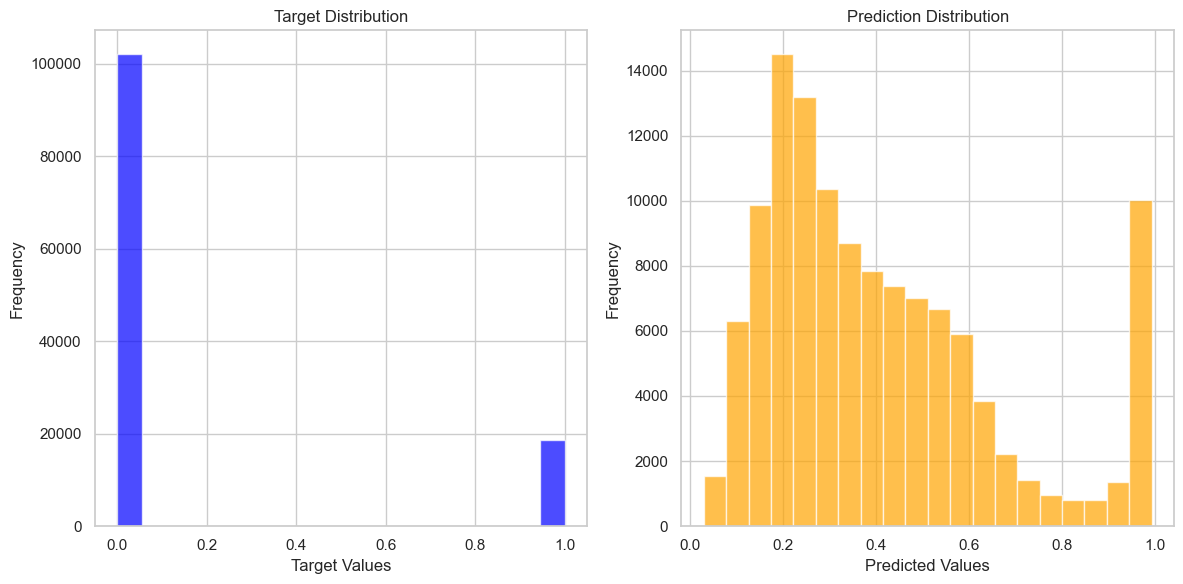

In [ ]:
import pickle

# Save the model to a file using pickle
# model_filename = os.path.join('models_nn_all', 'sepsis_lstm.pkl')
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)

# Load the model using pickle
model_filename = os.path.join('models_nn_all', 'sepsis_lstm.pkl')
with open(model_filename, 'rb') as file:
    model = pickle.load(file)


# Load test dataset
model_wrapped = ModelWrapped(model)
val_dataloader = dm.val_dataloader()

# List to store target and predicted values
targets = []
predictions = []

model_wrapped = ModelWrapped(model)

# Iterate over batches in the test dataloader
for idx, batch in enumerate(val_dataloader):
    # Assuming targets are in the first element of the batch tuple
    batch_targets = batch[1].clone()
    targets.extend(batch_targets.cpu().numpy())  # Convert to numpy if not already

    # Assuming LightningModule has a predict_step method
    # Make sure to move the batch to the same device as the model
    batch = [tensor.to('cpu') for tensor in batch]

    output = model_wrapped.predict_step(batch)

    # Assuming model returns raw logits, apply softmax to get probabilities
    probabilities = torch.sigmoid(output)
    predictions.extend(probabilities.cpu().detach().numpy())  # Convert to numpy if not already

# Convert the lists to PyTorch tensors for convenience
targets_tensor = torch.tensor(targets)
predictions_tensor = torch.tensor(predictions)

# Plot histograms for target and predicted distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(targets_tensor.numpy(), bins='auto', color='blue', alpha=0.7)
plt.title('Target Distribution')
plt.xlabel('Target Values')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predictions_tensor.numpy(), bins=20, color='orange', alpha=0.7)
plt.title('Prediction Distribution')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


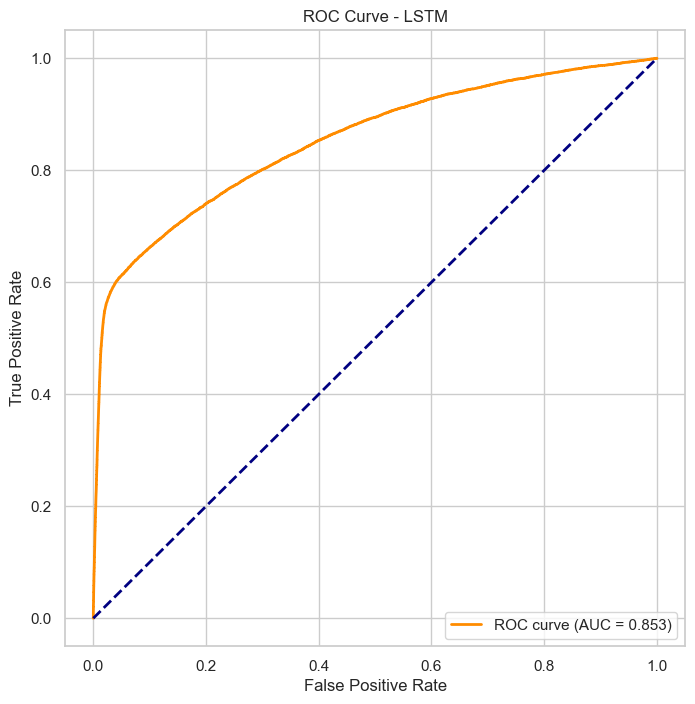

Balanced Accuracy with threshold 0.93: 0.74


In [12]:
import torch
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Convert the lists to NumPy arrays for convenience
targets_np = targets_tensor.numpy()
predictions_np = predictions_tensor.numpy()

# Calculate ROC curve
fpr_lstm, tpr_lstm, thresholds = roc_curve(targets_np, predictions_np)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(targets_np, predictions_np)

# Visualize ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()

# Calculate balanced accuracy with a threshold of 0.9
threshold = 0.93
binary_predictions = (predictions_np > threshold).astype(int)
balanced_acc = balanced_accuracy_score(targets_np, binary_predictions)

print(f'Balanced Accuracy with threshold {threshold}: {balanced_acc:.2f}')


DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


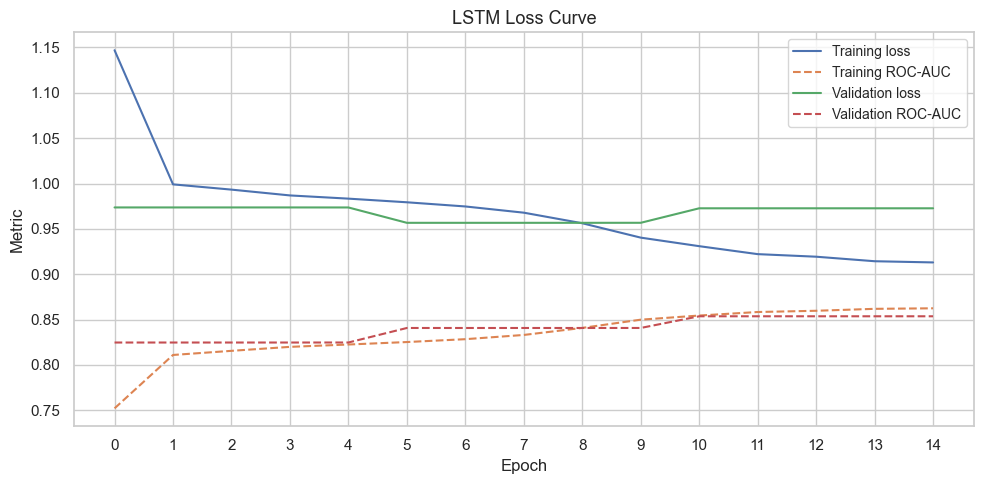

In [53]:
# The model seems to have reached the best performance at around 20th epoch
plot_loss_curve("csv_logs_all/lightning_logs/version_0", model_name='LSTM')

#### TCN (best hyperparams)

In [ ]:
# Create an instance of ModelWrapped
model = TemporalCNNModel(in_channels=51,
                 out_channels=20,
                 kernel_size=3,
                 dropout_rate=0.2,
                 output_size=1,
                 num_conv_layers=4).to(device)  # Replace with actual model
model_wrapped = ModelWrapped(model, lr=0.001)
val_dataloader = dm.val_dataloader()
# Logger type
logger = pl.loggers.CSVLogger('csv_logs_all')

# Specify the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Choose the metric to monitor (e.g., validation loss)
    patience=4,           # Number of epochs with no improvement after which training will be stopped
    mode='min'            # 'min' means training will stop when the monitored quantity has stopped decreasing
)

# Initialize the Lightning Trainer
trainer = pl.Trainer(
        logger=logger,
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=15,
        accelerator="gpu"
        #callbacks=[early_stopping_callback]
    )  # Adjust the number of GPUs as needed

pl.seed_everything(0)
trainer.fit(model_wrapped, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | TemporalCNNModel | 6.8 K 
-------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


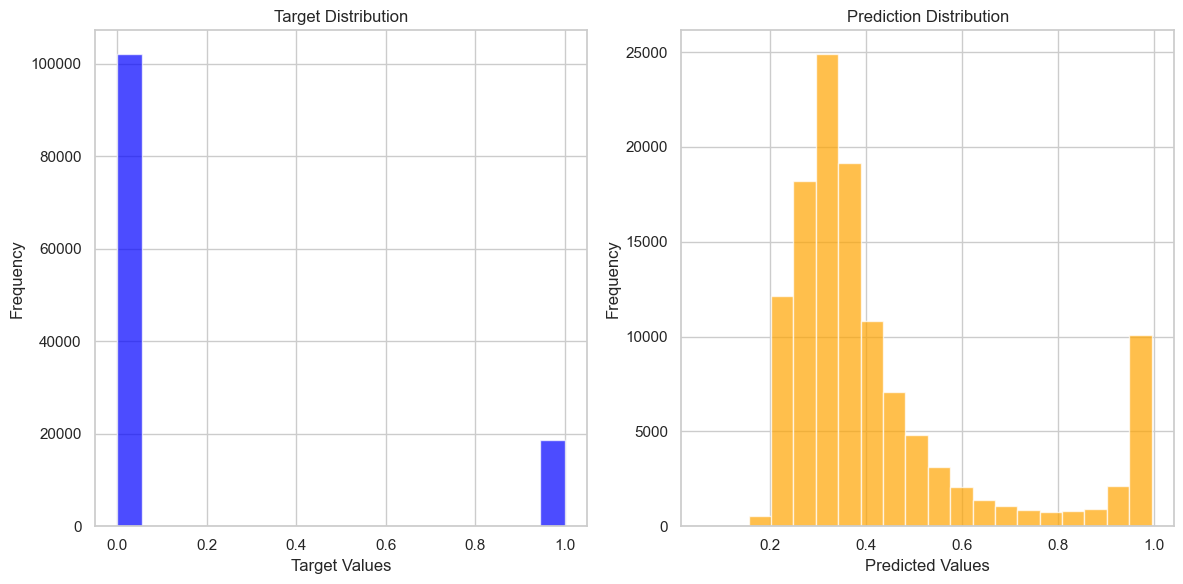

In [ ]:
import os
# Save the model to a file using pickle
# model_filename = os.path.join('models_nn_all', 'sepsis_tcn.pkl')
# with open(model_filename, 'wb') as file:
#      pickle.dump(model, file)
     
with open('models_nn_all/sepsis_tcn.pkl', 'rb') as f:
    model = pickle.load(f)


# Load test dataset
model_wrapped = ModelWrapped(model)
val_dataloader = dm.val_dataloader()

# List to store target and predicted values
targets = []
predictions = []

model_wrapped = ModelWrapped(model)

# Iterate over batches in the test dataloader
for idx, batch in enumerate(val_dataloader):
    # Assuming targets are in the first element of the batch tuple
    batch_targets = batch[1].clone()
    targets.extend(batch_targets.cpu().numpy())  # Convert to numpy if not already

    # Assuming LightningModule has a predict_step method
    # Make sure to move the batch to the same device as the model
    batch = [tensor.to('cpu') for tensor in batch]

    output = model_wrapped.predict_step(batch)

    # Assuming model returns raw logits, apply softmax to get probabilities
    probabilities = torch.sigmoid(output)
    predictions.extend(probabilities.cpu().detach().numpy())  # Convert to numpy if not already

# Convert the lists to PyTorch tensors for convenience
targets_tensor = torch.tensor(targets)
predictions_tensor = torch.tensor(predictions)

# Plot histograms for target and predicted distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(targets_tensor.numpy(), bins='auto', color='blue', alpha=0.7)
plt.title('Target Distribution')
plt.xlabel('Target Values')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predictions_tensor.numpy(), bins=20, color='orange', alpha=0.7)
plt.title('Prediction Distribution')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


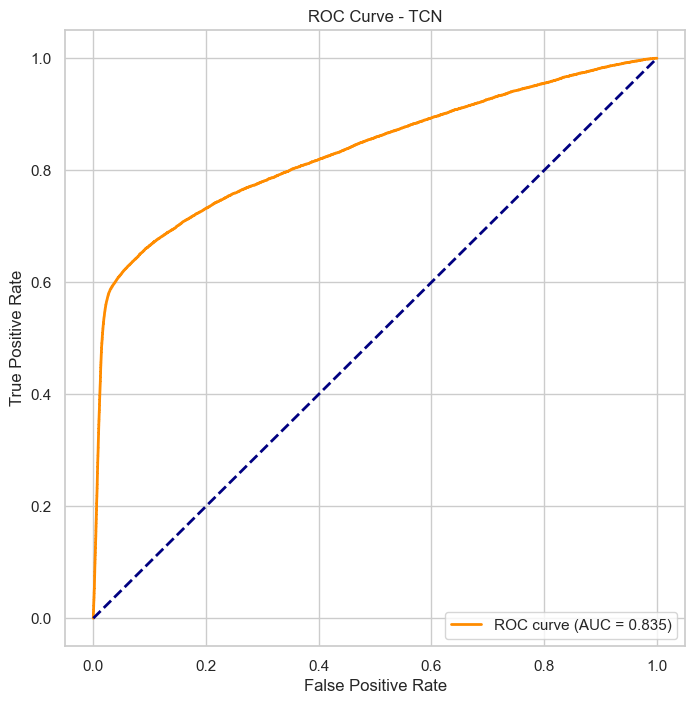

Balanced Accuracy with threshold 0.93: 0.75


In [14]:
import torch
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Convert the lists to NumPy arrays for convenience
targets_np = targets_tensor.numpy()
predictions_np = predictions_tensor.numpy()

# Calculate ROC curve
fpr_tcn, tpr_tcn, thresholds = roc_curve(targets_np, predictions_np)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(targets_np, predictions_np)

# Visualize ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_tcn, tpr_tcn, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TCN')
plt.legend(loc='lower right')
plt.show()

# Calculate balanced accuracy with a threshold of 0.9
threshold = 0.93
binary_predictions = (predictions_np > threshold).astype(int)
balanced_acc = balanced_accuracy_score(targets_np, binary_predictions)

print(f'Balanced Accuracy with threshold {threshold}: {balanced_acc:.2f}')


DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


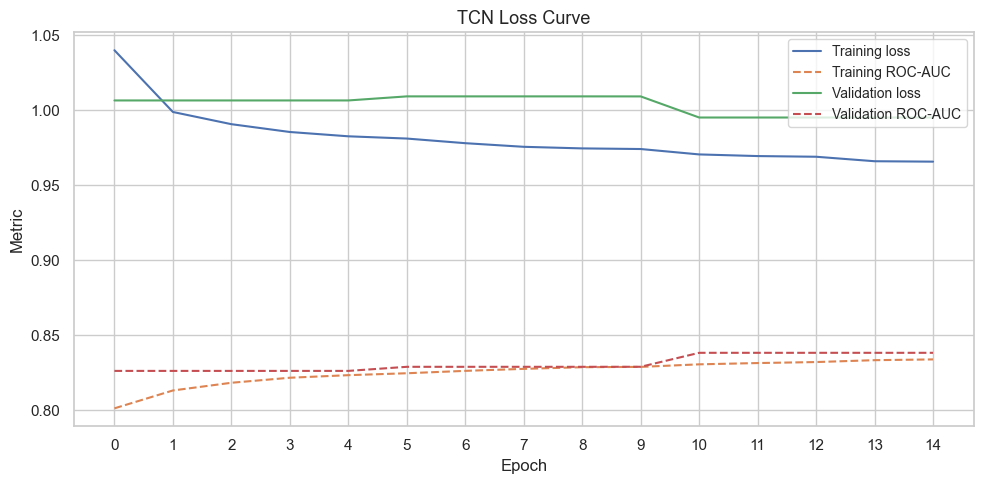

In [58]:
# The model seems to have reached the best performance at around 20th epoch
plot_loss_curve("csv_logs_all/lightning_logs/version_1", model_name='TCN')

#### ANN (best hyperparams)

In [9]:
# Create an instance of ModelWrapped
model = ANNModel(in_size=51,
                out_size=1,
                h_sizes=[80,40,20],
                dropout_rate=0.2,
                activ=nn.ReLU).to(device)
model_wrapped = ModelWrapped(model, lr=0.001)
logger = pl.loggers.CSVLogger('csv_logs_all')

# Specify the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Choose the metric to monitor (e.g., validation loss)
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    mode='min'            # 'min' means training will stop when the monitored quantity has stopped decreasing
)

# Initialize the Lightning Trainer
trainer = pl.Trainer(
        logger=logger,
        #limit_val_batches=PERCENT_VALID_EXAMPLES,
        enable_checkpointing=False,
        enable_progress_bar=True,
        max_epochs=15,
        accelerator="gpu"
        #callbacks=[early_stopping_callback]
    )  # Adjust the number of GPUs as needed


pl.seed_everything(0)
trainer.fit(model_wrapped, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ANNModel | 8.2 K 
-----------------------------------
8.2 K     Trainable params
0         Non-trainable params
8.2 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


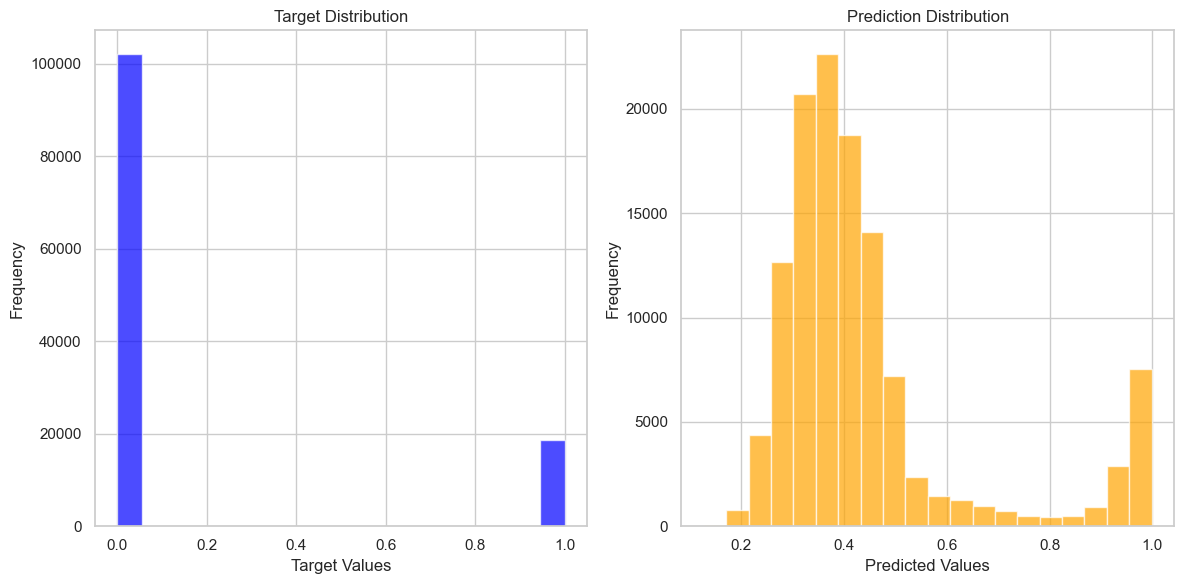

In [ ]:
# Save the model to a file using pickle
# model_filename = os.path.join('models_nn_all', 'sepsis_ann.pkl')
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)
    

# Save the model to a file using pickle
model_filename = os.path.join('models_nn_all', 'sepsis_ann.pkl')
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

# Load test dataset
model_wrapped = ModelWrapped(model)
val_dataloader = dm.val_dataloader()

# List to store target and predicted values
targets = []
predictions = []

model_wrapped = ModelWrapped(model)

# Iterate over batches in the test dataloader
for idx, batch in enumerate(val_dataloader):
    # Assuming targets are in the first element of the batch tuple
    batch_targets = batch[1].clone()
    targets.extend(batch_targets.cpu().numpy())  # Convert to numpy if not already

    # Assuming LightningModule has a predict_step method
    # Make sure to move the batch to the same device as the model
    batch = [tensor.to('cpu') for tensor in batch]

    output = model_wrapped.predict_step(batch)

    # Assuming model returns raw logits, apply softmax to get probabilities
    probabilities = torch.sigmoid(output)
    predictions.extend(probabilities.cpu().detach().numpy())  # Convert to numpy if not already

# Convert the lists to PyTorch tensors for convenience
targets_tensor = torch.tensor(targets)
predictions_tensor = torch.tensor(predictions)

# Plot histograms for target and predicted distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(targets_tensor.numpy(), bins='auto', color='blue', alpha=0.7)
plt.title('Target Distribution')
plt.xlabel('Target Values')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predictions_tensor.numpy(), bins=20, color='orange', alpha=0.7)
plt.title('Prediction Distribution')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


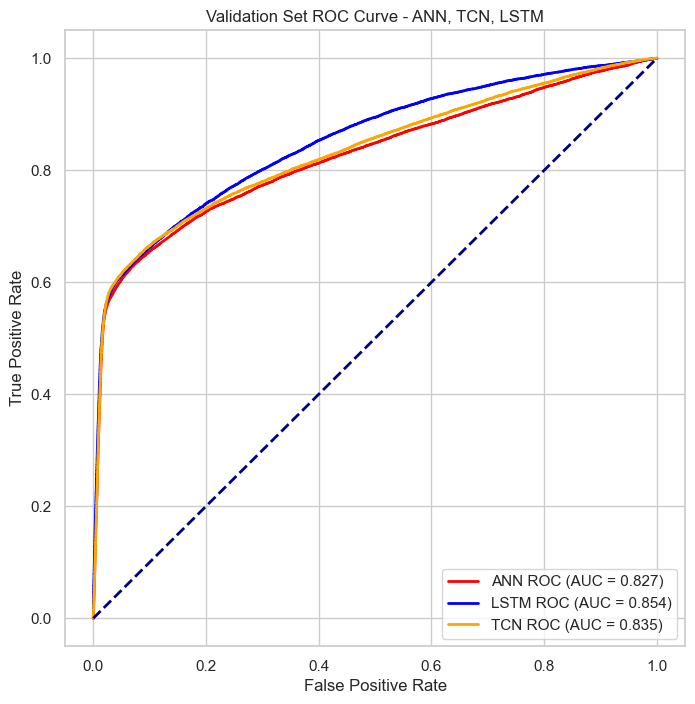

Balanced Accuracy with threshold 0.93: 0.71


In [18]:
import torch
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Convert the lists to NumPy arrays for convenience
targets_np = targets_tensor.numpy()
predictions_np = predictions_tensor.numpy()

# Calculate ROC curve
fpr_ann, tpr_ann, thresholds = roc_curve(targets_np, predictions_np)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(targets_np, predictions_np)

# Visualize ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_ann, tpr_ann, color='red', lw=2, label=f'ANN ROC (AUC = {roc_auc:.3f})')
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM ROC (AUC = {0.854:.3f})')
plt.plot(fpr_tcn, tpr_tcn, color='orange', lw=2, label=f'TCN ROC (AUC = {0.835:.3f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve - ANN, TCN, LSTM')
plt.legend(loc='lower right')
plt.show()

# Calculate balanced accuracy with a threshold of 0.9
threshold = 0.93
binary_predictions = (predictions_np > threshold).astype(int)
balanced_acc = balanced_accuracy_score(targets_np, binary_predictions)

print(f'Balanced Accuracy with threshold {threshold}: {balanced_acc:.2f}')


DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


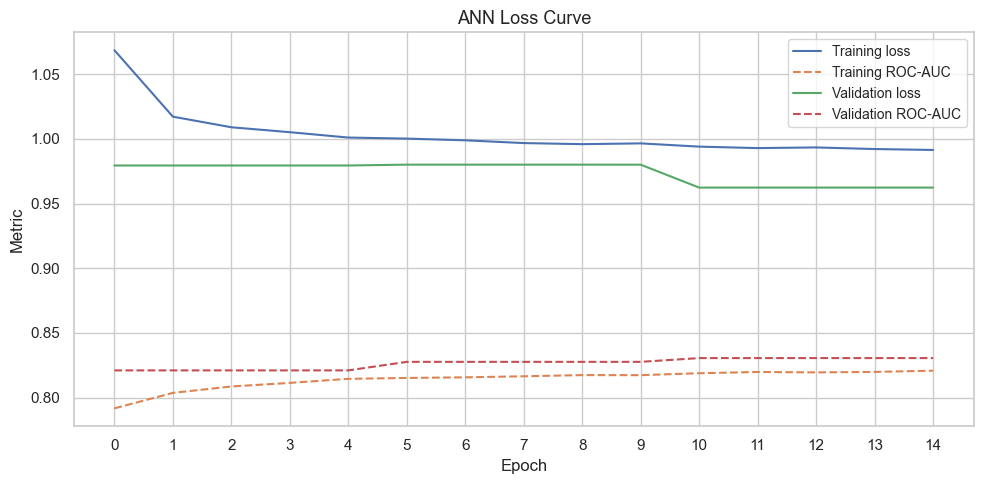

In [63]:
# The model seems to have reached the best performance at around 20th epoch
plot_loss_curve("csv_logs_all/lightning_logs/version_2", model_name='ANN')

### Shap values for the best model

torch.Size([120735, 20, 51])
torch.Size([2000, 20, 51])


unrecognized nn.Module: LSTM


(2000, 20, 51) (2000, 20, 51)


(-1.0, 1.0)

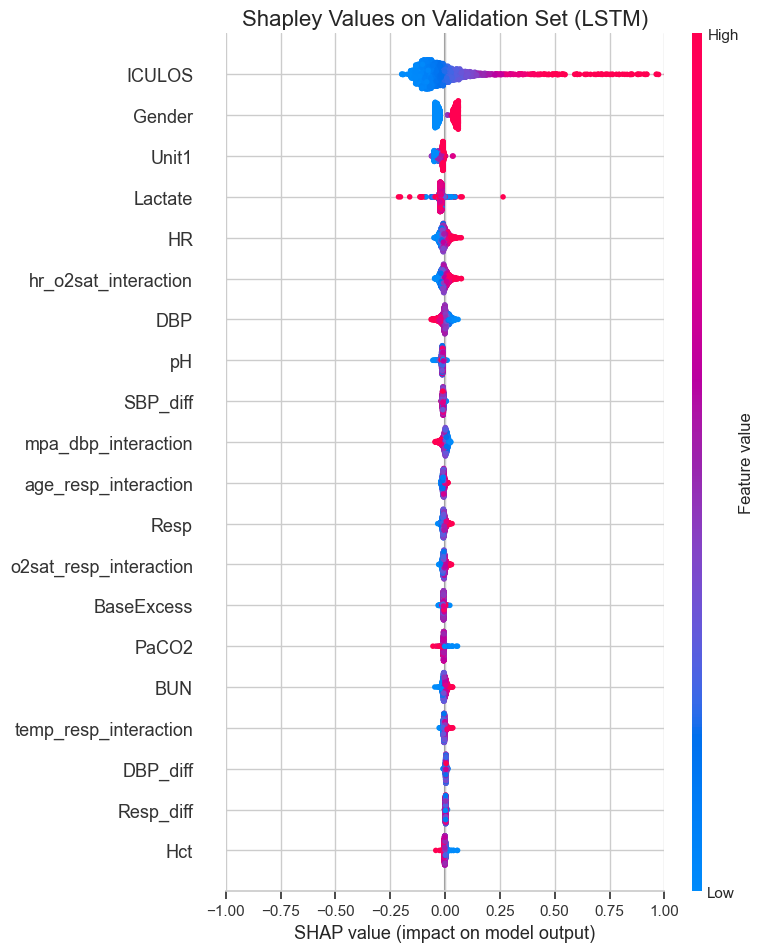

In [ ]:
# VAL SET LSTM
# Load the pre-trained model from the pickle file
model_path = 'models_nn_all/sepsis_lstm.pkl'  # Provide the path to pre-trained model
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

# Add a sigmoid layer on top of the model
sigmoid_layer = nn.Sigmoid()
modified_model = nn.Sequential(loaded_model, sigmoid_layer)

# Assuming DataLoader is named 'test_dataloader'
# Replace this with the actual DataLoader you have
val_dataloader = dm.val_dataloader()

# Set the model to evaluation mode
modified_model.eval()

# Concatenate entire val_dataloader into a single batch
all_samples = []
all_targets = []

for batch_data, batch_targets in val_dataloader:
    all_samples.append(batch_data)
    all_targets.append(batch_targets)

sample_data = torch.cat(all_samples[:2000], dim=0)
targets = torch.cat(all_targets[:2000], dim=0)
print(sample_data.size())

# Randomly select 100 samples
num_samples_to_select = 2000
random_indices = torch.randperm(sample_data.size(0))[:num_samples_to_select]
sample_data_selected = sample_data[random_indices]
print(sample_data_selected.size())

# samples for background
num_bsamples_to_select = 100
background_indices = torch.randperm(sample_data.size(0))[:num_bsamples_to_select]
background_data_selected = sample_data[random_indices]

# Move data to CPU if the model is on GPU
sample_data_selected = sample_data_selected.to('cpu')  # Modify if needed
background_data_selected  = background_data_selected .to('cpu')
modified_model = modified_model.to('cpu')

# Create the SHAP explainer
explainer = shap.DeepExplainer(modified_model, data=background_data_selected .detach())

# Calculate SHAP values for the sample data
shap_values = explainer.shap_values(sample_data_selected.detach(), check_additivity=False)

print(shap_values.shape, sample_data_selected.numpy().shape)

shap_values = np.sum(shap_values, axis=1)
sample_data_selected = np.sum(sample_data_selected.numpy(), axis=1)

# Plot the SHAP values
feature_names = dm.columns_to_keep
shap.summary_plot(shap_values, sample_data_selected, feature_names=feature_names, show=False, title = "Shapley values on Validation Set (LSTM")
plt.title("Shapley Values on Validation Set (LSTM)", fontsize = 16)
plt.xlim((-1,1))

In [8]:
# Calculate SHAP values for the sample data was : 
explainer.expected_value 

array([0.37022993], dtype=float32)

In [ ]:
# VAL SET LSTM
# Load the pre-trained model from the pickle file
model_path = 'models_nn_all/sepsis_tcn.pkl'  # Provide the path to pre-trained model
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

# Add a sigmoid layer on top of the model
sigmoid_layer = nn.Sigmoid()
modified_model = nn.Sequential(loaded_model, sigmoid_layer)

# Assuming DataLoader is named 'test_dataloader'
# Replace this with the actual DataLoader you have
val_dataloader = dm.val_dataloader()

# Set the model to evaluation mode
modified_model.eval()

# Concatenate entire val_dataloader into a single batch
all_samples = []
all_targets = []

for batch_data, batch_targets in val_dataloader:
    all_samples.append(batch_data)
    all_targets.append(batch_targets)

sample_data = torch.cat(all_samples[:2000], dim=0)
targets = torch.cat(all_targets[:10000], dim=0)
print(sample_data.size())

# Randomly select 100 samples
num_samples_to_select = 2000
random_indices = torch.randperm(sample_data.size(0))[:num_samples_to_select]
sample_data_selected = sample_data[random_indices]
print(sample_data_selected.size())

# samples for background
num_bsamples_to_select = 100
background_indices = torch.randperm(sample_data.size(0))[:num_bsamples_to_select]
background_data_selected = sample_data[random_indices]

# Move data to GPU if the model is on GPU
sample_data_selected = sample_data_selected.to('cpu')  # Modify if needed
background_data_selected = background_data_selected.to('cpu') 
modified_model = modified_model.to('cpu')

# Create the SHAP explainer
explainer = shap.DeepExplainer(modified_model, data=background_data_selected.detach())

# Calculate SHAP values for the sample data
shap_values = explainer.shap_values(sample_data_selected.detach(), check_additivity=False)
print(shap_values.shape, sample_data_selected.numpy().shape)

shap_values = np.sum(shap_values, axis=1)
sample_data_selected = np.sum(sample_data_selected.numpy(), axis=1)

# Plot the SHAP values
feature_names = dm.columns_to_keep
shap.summary_plot(shap_values, sample_data_selected, feature_names=feature_names, show=False, title = "Shapley Values on validation sample (TCN)")
plt.title("Shapley Values on Validation Set (TCN)", fontsize = 16)

In [ ]:
explainer.expected_value 

array([0.47062057], dtype=float32)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, sample_data_selected, feature_names=feature_names)